In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
import os
import geopandas as gpd
from tobler.area_weighted import area_interpolate
from tobler.dasymetric import masked_area_interpolate

In [2]:
path = os.getcwd()+ '\Dados vetoriais\Pontos amostrais_Piracicaba\Dados_227pts_original_06_03_2021.shp'
pontos_pira = gpd.read_file(path)

In [3]:
path2 = os.getcwd()+ '\Dados vetoriais\Piracicaba\Perimetro_Piracicaba.shp'
perimetro_pira = gpd.read_file(path2)


In [4]:
xizes = []
ypsolons = []

for geom in perimetro_pira.exterior:
    if(geom == None):
        continue
    xizes.append(geom.coords.xy[0])
    ypsolons.append(geom.coords.xy[1])

xizes = list(np.concatenate(xizes).flat)
ypsolons = list(np.concatenate(ypsolons).flat)

all_dots = [list(xy) for xy in zip(xizes, ypsolons)]

In [5]:
# split the data into featutes and target variable seperately
variaveis = pontos_pira.iloc[:, [1,2]].values # features set
argila = pontos_pira.iloc[:, 6].values # set of study variable

In [6]:
argila = argila.reshape(-1,1)

In [7]:
from sklearn.preprocessing import StandardScaler
StdS_X = StandardScaler()
StdS_y = StandardScaler()
variaveis = StdS_X.fit_transform(variaveis)
argila = StdS_y.fit_transform(argila)

In [8]:
# import the model
from sklearn.svm import SVR
# create the model object
regressor = SVR(kernel = 'rbf')
# fit the model on the data
regressor.fit(variaveis, argila.ravel())

SVR()

In [9]:
A=regressor.predict(StdS_X.transform(np.vstack((xizes, ypsolons)).T))

In [10]:
path = os.getcwd()+ '\Dados vetoriais\Pontos amostrais_Piracicaba\Dados_227pts_original_06_03_2021.shp'
pontos_pira_gpd = gpd.read_file(path)

In [11]:
path2 = os.getcwd()+ '\Dados vetoriais\Piracicaba\Perimetro_Piracicaba.shp'
mapa_pira = gpd.read_file(path2)

In [12]:
# fig, ax = plt.subplots(figsize = (18,16))
# mapa_pira.plot(color="gray",edgecolor="blue", ax=ax, legend=True)
# pontos_pira_gpd.plot(color="black", edgecolor="white",  ax=ax, alpha=.5, legend=True)

In [13]:
import json
from types import SimpleNamespace

mapa_pira["constant"] = 1
mapa_pira_dissolved = mapa_pira.dissolve(by = "constant").reset_index(drop = True)

asd = mapa_pira_dissolved.geometry
data = asd.to_json()

x = json.loads(data, object_hook=lambda d: SimpleNamespace(**d))
coordinates = x.features[0].geometry.coordinates
geometries = [item for sublist in coordinates for item in sublist]
geometries2 = [item for sublist in geometries for item in sublist]

geometries2.sort(key=lambda x:x[0])

In [14]:
import numpy as np
from shapely.geometry import Point
from shapely.ops import unary_union
import geopandas as gpd

def generate_grid_in_polygon(spacing, polygon):
    ''' This Function generates evenly spaced points within the given GeoDataFrame.
        The parameter 'spacing' defines the distance between the points in coordinate units. '''
    
    # Convert the GeoDataFrame to a single polygon
    poly_in = unary_union([poly for poly in polygon.geometry])

    # Get the bounds of the polygon
    minx, miny, maxx, maxy = poly_in.bounds    
    
    # Now generate the entire grid
    x_coords = list(np.arange(np.floor(minx), int(np.ceil(maxx)), spacing))
    y_coords = list(np.arange(np.floor(miny), int(np.ceil(maxy)), spacing))
    
    grid = [Point(x) for x in zip(np.meshgrid(x_coords, y_coords)[0].flatten(), np.meshgrid(x_coords, y_coords)[1].flatten())]

    # Finally only keep the points within the polygon
    list_of_points = [point for point in grid if point.within(poly_in)]
    # list_of_points = [point for point in grid if poly_in.intersects(point)]

    return list_of_points

In [15]:
points_in_poly = generate_grid_in_polygon(500, mapa_pira_dissolved)
points_in_poly_gdf = gpd.GeoDataFrame(geometry=points_in_poly)

pointList = [[point.x, point.y] for point in points_in_poly]

xgerados = [point.x for point in points_in_poly]
ygerados = [point.y for point in points_in_poly]

In [ ]:
fig, ax = plt.subplots(figsize = (50,50))
mapa_pira_dissolved.plot(ax=ax,facecolor='none', edgecolor='k')
points_in_poly_gdf.plot(ax=ax)

In [17]:
B=regressor.predict(StdS_X.transform(pointList))

In [18]:
dataFrameGerado = pd.DataFrame({'X':xgerados, 'Y': ygerados, 'Argila': B})

<AxesSubplot:>

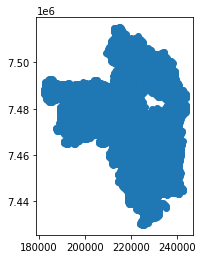

In [19]:
mapa_gerado = gpd.GeoDataFrame(dataFrameGerado, geometry=gpd.points_from_xy(dataFrameGerado.X, dataFrameGerado.Y), crs = mapa_pira.crs)
mapa_gerado.plot()

<AxesSubplot:>

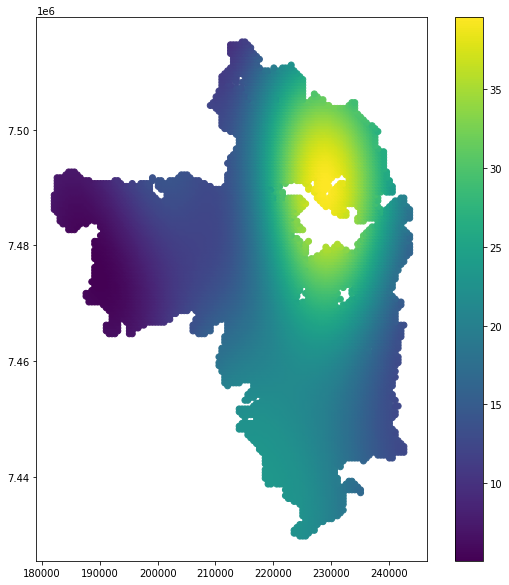

In [20]:
mapa_gerado["Argila"] = StdS_y.inverse_transform(B.reshape(-1,1))
fig, ax = plt.subplots(figsize = (10,10))
mapa_gerado.plot("Argila",ax=ax, legend=True)